This notebook contains the necessary scripts for making the base case model.

In [1]:
### Starting with the import of the necessary libraries:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
from scipy.stats import linregress
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
C:\Users\po7517\Anaconda3\envs\new_env\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
### either CPU or GPU:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
### Reading the dummy data
all_data = pd.read_csv('data/all_data_dummy.csv')

In [4]:
def pytorch_NN(all_data, input_features, target_variables, weight_decay=1e-3, patience=100):
    '''
    This function reads the data and based on the interest of the user, different 
    input features and target variables can be selected from the existing measured
    parameters.
    weight_decay is a regularization technique used to prevent overfitting by penalizing 
    large weights in the model. More details at 
    https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    patience refers to the number of training epochs to wait after the last improvement 
    in the monitored metric (e.g., validation loss, accuracy) before stopping the training process.
    More details at https://pytorch.org/ignite/generated/ignite.handlers.early_stopping.EarlyStopping.html
    '''
    ### The next block of code prepares the data
    X = all_data[input_features].to_numpy()
    y = all_data[target_variables].to_numpy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    scaler_x = RobustScaler()
    scaler_y = RobustScaler()
    X_train_norm = scaler_x.fit_transform(X_train)
    X_test_norm = scaler_x.transform(X_test)
    y_train_norm = scaler_y.fit_transform(y_train)
    y_test_norm = scaler_y.transform(y_test)
    XX = torch.from_numpy(X_train_norm.astype(np.float32)).to(device)
    yy = torch.from_numpy(y_train_norm.astype(np.float32)).to(device)
    n_samples, n_features = XX.shape
    input_size = n_features
    output_size = yy.shape[1]
    
    class NN(nn.Module):
        def __init__(self):
            super(NN, self).__init__()
            self.fc1 = nn.Linear(n_features, 32) # Input layer to hidden layer
            self.norm1 = nn.BatchNorm1d(32) # Batch normalization
            self.fc2 = nn.Linear(32, 16) # Hidden layer to hidden layer
            self.norm2 = nn.BatchNorm1d(16) # Batch normalization
            self.fc3 = nn.Linear(16, output_size) # Hidden layer to output layer

        def forward(self, x):
            x = torch.relu(self.fc1(x)) # applying relu activation
            x = self.norm1(x) # applying the batch normalization
            x = torch.relu(self.fc2(x))
            x = self.norm2(x)
            x = self.fc3(x)
            return x
 
    model = NN().to(device) # contruction of the model

    # Define the loss function and optimizer
    criterion = nn.L1Loss()
    optimizer = optim.Adam(model.parameters(), lr=0.1, weight_decay=weight_decay)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=patience, verbose=True)
    # Training loop with early stopping
    num_epochs = 2000
    best_loss = float('inf')
    patience_counter = 0
    loss_values = []
    loss_train = []
    for epoch in range(num_epochs):
        def closure():
            optimizer.zero_grad()
            outputs = model(XX)
            loss = criterion(outputs, yy)
            loss.backward()
            loss_train.append(loss.item())
            return loss

        # Perform optimization step
        optimizer.step(closure)

        model.eval()
        with torch.no_grad():
            val_outputs = model(torch.from_numpy(X_test_norm.astype(np.float32)).to(device))
            val_loss = criterion(val_outputs, torch.from_numpy(y_test_norm.astype(np.float32)).to(device))
            
        scheduler.step(val_loss)
        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience: # looking for the improve of the loss
            print(f'Early stopping at epoch {epoch+1}')
            break

        if (epoch+1) % 100 == 0: # printg out each 100th epoch
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {val_loss.item():.4f}, Val Loss: {val_loss.item():.4f}')

        loss_values.append(val_loss.item())

    print("Training complete.")
    # using the trained model to predict for the test data
    predicted = model(torch.from_numpy(X_test_norm.astype(np.float32)).to(device)).detach().cpu().numpy()
    predicted_original_scale = scaler_y.inverse_transform(predicted)
    y_test_original_scale = scaler_y.inverse_transform(y_test_norm)
    
    # using the trained model to predict for the train data
    predicted_tr = model(torch.from_numpy(X_train_norm.astype(np.float32)).to(device)).detach().cpu().numpy()
    predicted_original_scale_tr = scaler_y.inverse_transform(predicted_tr)
    y_train_original_scale = scaler_y.inverse_transform(y_train_norm)

    r_values = [] # collects the r value between the measured test and predicted test cases
    for i in range(len(target_variables)):
        slope, intercept, r_value, p_value, std_err = linregress(y_test_original_scale[:, i], predicted_original_scale[:, i])
        r_values.append(r_value)
    
    return r_values, y_test_original_scale, predicted_original_scale, y_train_original_scale, predicted_original_scale_tr, loss_train, loss_values 

In [5]:
target_variables = ['B', 'V', 'Cr', 'Mn', 'Co', 'Ni', 'Cu', 'Zn', 'Ga', 'Be',
                    'As', 'Rb', 'Sr', 'Y', 'Mo', 'Cd', 'Sb', 'Cs', 'Ba', 'Pb'] # to be predicted
input_features = ['Li', 'Na', 'Ca', 'SO-', 'Cl-', 'Br-', 'Al', 'Si', 'pH', 'F-', 'Fe', 'Mg']
import time
start = time.time()
results = []
### Making an ensemble of 1000 models
for i in range(1000):
    print(f'Starting Round {i}')
    r_values, test_y, predicted_y, train_y, predicted_y_train, l_tr, l_te = pytorch_NN(all_data, input_features, target_variables)
    results.append({
        'r_values': r_values,
        'test_y': test_y,
        'predicted_y': predicted_y,
        'train_y': train_y,
        'predicted_y_train': predicted_y_train,
        'l_tr': l_tr,
        'l_te': l_te,
    })
end = time.time()
print(f'{(end - start)/60} mins')

Starting Round 0
Epoch [100/2000], Loss: 0.2505, Val Loss: 0.2505
Epoch [200/2000], Loss: 0.2555, Val Loss: 0.2555
Early stopping at epoch 211
Training complete.
Starting Round 1
Epoch [100/2000], Loss: 0.2425, Val Loss: 0.2425
Epoch [200/2000], Loss: 0.2434, Val Loss: 0.2434
Early stopping at epoch 220
Training complete.
Starting Round 2
Epoch [100/2000], Loss: 0.2330, Val Loss: 0.2330
Early stopping at epoch 160
Training complete.
Starting Round 3
Epoch [100/2000], Loss: 0.2676, Val Loss: 0.2676
Early stopping at epoch 151
Training complete.
Starting Round 4
Epoch [100/2000], Loss: 0.2395, Val Loss: 0.2395
Epoch [200/2000], Loss: 0.2517, Val Loss: 0.2517
Early stopping at epoch 273
Training complete.
Starting Round 5
Epoch [100/2000], Loss: 0.3095, Val Loss: 0.3095
Early stopping at epoch 180
Training complete.
Starting Round 6
Epoch [100/2000], Loss: 0.2550, Val Loss: 0.2550
Early stopping at epoch 158
Training complete.
Starting Round 7
Epoch [100/2000], Loss: 0.2684, Val Loss: 0.2

Epoch [100/2000], Loss: 0.2232, Val Loss: 0.2232
Early stopping at epoch 190
Training complete.
Starting Round 54
Epoch [100/2000], Loss: 0.2541, Val Loss: 0.2541
Epoch [200/2000], Loss: 0.2791, Val Loss: 0.2791
Early stopping at epoch 225
Training complete.
Starting Round 55
Epoch [100/2000], Loss: 0.2955, Val Loss: 0.2955
Epoch [200/2000], Loss: 0.2806, Val Loss: 0.2806
Epoch [300/2000], Loss: 0.2794, Val Loss: 0.2794
Epoch [400/2000], Loss: 0.2677, Val Loss: 0.2677
Early stopping at epoch 420
Training complete.
Starting Round 56
Epoch [100/2000], Loss: 0.2908, Val Loss: 0.2908
Epoch [200/2000], Loss: 0.2882, Val Loss: 0.2882
Early stopping at epoch 279
Training complete.
Starting Round 57
Epoch [100/2000], Loss: 0.2732, Val Loss: 0.2732
Epoch [200/2000], Loss: 0.2519, Val Loss: 0.2519
Early stopping at epoch 277
Training complete.
Starting Round 58
Epoch [100/2000], Loss: 0.2515, Val Loss: 0.2515
Early stopping at epoch 191
Training complete.
Starting Round 59
Epoch [100/2000], Loss

Epoch [100/2000], Loss: 0.2583, Val Loss: 0.2583
Epoch [200/2000], Loss: 0.2625, Val Loss: 0.2625
Early stopping at epoch 227
Training complete.
Starting Round 103
Epoch [100/2000], Loss: 0.2962, Val Loss: 0.2962
Epoch [200/2000], Loss: 0.3003, Val Loss: 0.3003
Early stopping at epoch 215
Training complete.
Starting Round 104
Epoch [100/2000], Loss: 0.2813, Val Loss: 0.2813
Epoch [200/2000], Loss: 0.2824, Val Loss: 0.2824
Epoch [300/2000], Loss: 0.2920, Val Loss: 0.2920
Early stopping at epoch 317
Training complete.
Starting Round 105
Epoch [100/2000], Loss: 0.2897, Val Loss: 0.2897
Early stopping at epoch 180
Training complete.
Starting Round 106
Epoch [100/2000], Loss: 0.2861, Val Loss: 0.2861
Epoch [200/2000], Loss: 0.2744, Val Loss: 0.2744
Early stopping at epoch 295
Training complete.
Starting Round 107
Epoch [100/2000], Loss: 0.2724, Val Loss: 0.2724
Epoch [200/2000], Loss: 0.2642, Val Loss: 0.2642
Early stopping at epoch 222
Training complete.
Starting Round 108
Epoch [100/2000]

Epoch [100/2000], Loss: 0.2815, Val Loss: 0.2815
Early stopping at epoch 193
Training complete.
Starting Round 155
Epoch [100/2000], Loss: 0.2677, Val Loss: 0.2677
Epoch [200/2000], Loss: 0.2507, Val Loss: 0.2507
Epoch [300/2000], Loss: 0.2485, Val Loss: 0.2485
Epoch [400/2000], Loss: 0.2444, Val Loss: 0.2444
Epoch [500/2000], Loss: 0.2522, Val Loss: 0.2522
Early stopping at epoch 501
Training complete.
Starting Round 156
Epoch [100/2000], Loss: 0.2429, Val Loss: 0.2429
Epoch [200/2000], Loss: 0.2244, Val Loss: 0.2244
Early stopping at epoch 238
Training complete.
Starting Round 157
Epoch [100/2000], Loss: 0.2456, Val Loss: 0.2456
Epoch [200/2000], Loss: 0.2466, Val Loss: 0.2466
Early stopping at epoch 269
Training complete.
Starting Round 158
Epoch [100/2000], Loss: 0.2426, Val Loss: 0.2426
Epoch [200/2000], Loss: 0.2295, Val Loss: 0.2295
Epoch [300/2000], Loss: 0.2260, Val Loss: 0.2260
Epoch [400/2000], Loss: 0.2206, Val Loss: 0.2206
Early stopping at epoch 492
Training complete.
Sta

Epoch [100/2000], Loss: 0.2014, Val Loss: 0.2014
Epoch [200/2000], Loss: 0.2011, Val Loss: 0.2011
Early stopping at epoch 263
Training complete.
Starting Round 202
Epoch [100/2000], Loss: 0.2730, Val Loss: 0.2730
Early stopping at epoch 194
Training complete.
Starting Round 203
Epoch [100/2000], Loss: 0.2645, Val Loss: 0.2645
Epoch [200/2000], Loss: 0.2538, Val Loss: 0.2538
Early stopping at epoch 245
Training complete.
Starting Round 204
Epoch [100/2000], Loss: 0.2812, Val Loss: 0.2812
Epoch [200/2000], Loss: 0.2655, Val Loss: 0.2655
Epoch [300/2000], Loss: 0.2632, Val Loss: 0.2632
Early stopping at epoch 309
Training complete.
Starting Round 205
Epoch [100/2000], Loss: 0.2558, Val Loss: 0.2558
Epoch [200/2000], Loss: 0.2479, Val Loss: 0.2479
Epoch [300/2000], Loss: 0.2427, Val Loss: 0.2427
Early stopping at epoch 367
Training complete.
Starting Round 206
Epoch [100/2000], Loss: 0.2385, Val Loss: 0.2385
Epoch [200/2000], Loss: 0.2386, Val Loss: 0.2386
Early stopping at epoch 201
Train

Early stopping at epoch 354
Training complete.
Starting Round 247
Epoch [100/2000], Loss: 0.2322, Val Loss: 0.2322
Epoch [200/2000], Loss: 0.2564, Val Loss: 0.2564
Early stopping at epoch 238
Training complete.
Starting Round 248
Epoch [100/2000], Loss: 0.2407, Val Loss: 0.2407
Early stopping at epoch 174
Training complete.
Starting Round 249
Epoch [100/2000], Loss: 0.2556, Val Loss: 0.2556
Epoch [200/2000], Loss: 0.2692, Val Loss: 0.2692
Epoch [300/2000], Loss: 0.2448, Val Loss: 0.2448
Epoch [400/2000], Loss: 0.2372, Val Loss: 0.2372
Early stopping at epoch 408
Training complete.
Starting Round 250
Epoch [100/2000], Loss: 0.2607, Val Loss: 0.2607
Epoch [200/2000], Loss: 0.2655, Val Loss: 0.2655
Early stopping at epoch 206
Training complete.
Starting Round 251
Epoch [100/2000], Loss: 0.2530, Val Loss: 0.2530
Early stopping at epoch 162
Training complete.
Starting Round 252
Epoch [100/2000], Loss: 0.2632, Val Loss: 0.2632
Epoch [200/2000], Loss: 0.2639, Val Loss: 0.2639
Early stopping a

Early stopping at epoch 348
Training complete.
Starting Round 296
Epoch [100/2000], Loss: 0.2482, Val Loss: 0.2482
Early stopping at epoch 191
Training complete.
Starting Round 297
Epoch [100/2000], Loss: 0.2712, Val Loss: 0.2712
Early stopping at epoch 185
Training complete.
Starting Round 298
Epoch [100/2000], Loss: 0.2678, Val Loss: 0.2678
Epoch [200/2000], Loss: 0.2738, Val Loss: 0.2738
Early stopping at epoch 213
Training complete.
Starting Round 299
Epoch [100/2000], Loss: 0.2719, Val Loss: 0.2719
Epoch [200/2000], Loss: 0.2543, Val Loss: 0.2543
Epoch [300/2000], Loss: 0.2636, Val Loss: 0.2636
Early stopping at epoch 346
Training complete.
Starting Round 300
Epoch [100/2000], Loss: 0.2505, Val Loss: 0.2505
Epoch [200/2000], Loss: 0.2437, Val Loss: 0.2437
Early stopping at epoch 297
Training complete.
Starting Round 301
Epoch [100/2000], Loss: 0.2742, Val Loss: 0.2742
Epoch [200/2000], Loss: 0.2469, Val Loss: 0.2469
Epoch [300/2000], Loss: 0.2554, Val Loss: 0.2554
Early stopping a

Epoch [200/2000], Loss: 0.2961, Val Loss: 0.2961
Early stopping at epoch 272
Training complete.
Starting Round 338
Epoch [100/2000], Loss: 0.2947, Val Loss: 0.2947
Early stopping at epoch 172
Training complete.
Starting Round 339
Epoch [100/2000], Loss: 0.2306, Val Loss: 0.2306
Epoch [200/2000], Loss: 0.2259, Val Loss: 0.2259
Early stopping at epoch 256
Training complete.
Starting Round 340
Epoch [100/2000], Loss: 0.3313, Val Loss: 0.3313
Epoch [200/2000], Loss: 0.3426, Val Loss: 0.3426
Early stopping at epoch 205
Training complete.
Starting Round 341
Epoch [100/2000], Loss: 0.3013, Val Loss: 0.3013
Epoch [200/2000], Loss: 0.2879, Val Loss: 0.2879
Epoch [300/2000], Loss: 0.2905, Val Loss: 0.2905
Epoch [400/2000], Loss: 0.2879, Val Loss: 0.2879
Early stopping at epoch 482
Training complete.
Starting Round 342
Epoch [100/2000], Loss: 0.2660, Val Loss: 0.2660
Epoch [200/2000], Loss: 0.2392, Val Loss: 0.2392
Early stopping at epoch 297
Training complete.
Starting Round 343
Epoch [100/2000]

Epoch [200/2000], Loss: 0.2247, Val Loss: 0.2247
Early stopping at epoch 282
Training complete.
Starting Round 387
Epoch [100/2000], Loss: 0.2356, Val Loss: 0.2356
Epoch [200/2000], Loss: 0.2349, Val Loss: 0.2349
Early stopping at epoch 204
Training complete.
Starting Round 388
Epoch [100/2000], Loss: 0.2769, Val Loss: 0.2769
Epoch 00154: reducing learning rate of group 0 to 1.0000e-02.
Early stopping at epoch 175
Training complete.
Starting Round 389
Epoch [100/2000], Loss: 0.3113, Val Loss: 0.3113
Early stopping at epoch 137
Training complete.
Starting Round 390
Epoch [100/2000], Loss: 0.2573, Val Loss: 0.2573
Early stopping at epoch 200
Training complete.
Starting Round 391
Epoch [100/2000], Loss: 0.2422, Val Loss: 0.2422
Epoch [200/2000], Loss: 0.2352, Val Loss: 0.2352
Early stopping at epoch 257
Training complete.
Starting Round 392
Epoch [100/2000], Loss: 0.2459, Val Loss: 0.2459
Epoch [200/2000], Loss: 0.2805, Val Loss: 0.2805
Early stopping at epoch 236
Training complete.
Start

Epoch [100/2000], Loss: 0.2346, Val Loss: 0.2346
Epoch [200/2000], Loss: 0.2442, Val Loss: 0.2442
Early stopping at epoch 228
Training complete.
Starting Round 439
Epoch [100/2000], Loss: 0.2393, Val Loss: 0.2393
Early stopping at epoch 183
Training complete.
Starting Round 440
Epoch [100/2000], Loss: 0.2807, Val Loss: 0.2807
Epoch [200/2000], Loss: 0.2697, Val Loss: 0.2697
Epoch [300/2000], Loss: 0.2672, Val Loss: 0.2672
Early stopping at epoch 325
Training complete.
Starting Round 441
Epoch [100/2000], Loss: 0.3002, Val Loss: 0.3002
Epoch [200/2000], Loss: 0.2880, Val Loss: 0.2880
Epoch [300/2000], Loss: 0.2884, Val Loss: 0.2884
Early stopping at epoch 363
Training complete.
Starting Round 442
Epoch [100/2000], Loss: 0.2264, Val Loss: 0.2264
Early stopping at epoch 189
Training complete.
Starting Round 443
Epoch [100/2000], Loss: 0.2889, Val Loss: 0.2889
Epoch [200/2000], Loss: 0.2804, Val Loss: 0.2804
Early stopping at epoch 218
Training complete.
Starting Round 444
Epoch [100/2000]

Epoch [300/2000], Loss: 0.2261, Val Loss: 0.2261
Early stopping at epoch 355
Training complete.
Starting Round 492
Epoch [100/2000], Loss: 0.2417, Val Loss: 0.2417
Epoch [200/2000], Loss: 0.2387, Val Loss: 0.2387
Epoch [300/2000], Loss: 0.2318, Val Loss: 0.2318
Early stopping at epoch 307
Training complete.
Starting Round 493
Epoch [100/2000], Loss: 0.2793, Val Loss: 0.2793
Epoch [200/2000], Loss: 0.2748, Val Loss: 0.2748
Epoch [300/2000], Loss: 0.2716, Val Loss: 0.2716
Epoch [400/2000], Loss: 0.2724, Val Loss: 0.2724
Early stopping at epoch 409
Training complete.
Starting Round 494
Epoch [100/2000], Loss: 0.2350, Val Loss: 0.2350
Epoch [200/2000], Loss: 0.2524, Val Loss: 0.2524
Early stopping at epoch 237
Training complete.
Starting Round 495
Epoch [100/2000], Loss: 0.2673, Val Loss: 0.2673
Epoch [200/2000], Loss: 0.2446, Val Loss: 0.2446
Epoch [300/2000], Loss: 0.2523, Val Loss: 0.2523
Epoch [400/2000], Loss: 0.2573, Val Loss: 0.2573
Early stopping at epoch 435
Training complete.
Sta

Epoch [300/2000], Loss: 0.2466, Val Loss: 0.2466
Early stopping at epoch 336
Training complete.
Starting Round 539
Epoch [100/2000], Loss: 0.2678, Val Loss: 0.2678
Early stopping at epoch 198
Training complete.
Starting Round 540
Epoch [100/2000], Loss: 0.2798, Val Loss: 0.2798
Epoch [200/2000], Loss: 0.2784, Val Loss: 0.2784
Early stopping at epoch 237
Training complete.
Starting Round 541
Epoch [100/2000], Loss: 0.3180, Val Loss: 0.3180
Epoch [200/2000], Loss: 0.2858, Val Loss: 0.2858
Epoch [300/2000], Loss: 0.2857, Val Loss: 0.2857
Epoch [400/2000], Loss: 0.2886, Val Loss: 0.2886
Early stopping at epoch 441
Training complete.
Starting Round 542
Epoch [100/2000], Loss: 0.2990, Val Loss: 0.2990
Early stopping at epoch 174
Training complete.
Starting Round 543
Epoch [100/2000], Loss: 0.2520, Val Loss: 0.2520
Epoch [200/2000], Loss: 0.2546, Val Loss: 0.2546
Epoch [300/2000], Loss: 0.2569, Val Loss: 0.2569
Early stopping at epoch 309
Training complete.
Starting Round 544
Epoch [100/2000]

Early stopping at epoch 267
Training complete.
Starting Round 589
Epoch [100/2000], Loss: 0.2977, Val Loss: 0.2977
Epoch [200/2000], Loss: 0.2964, Val Loss: 0.2964
Early stopping at epoch 244
Training complete.
Starting Round 590
Epoch [100/2000], Loss: 0.3508, Val Loss: 0.3508
Epoch [200/2000], Loss: 0.3473, Val Loss: 0.3473
Epoch [300/2000], Loss: 0.3322, Val Loss: 0.3322
Epoch [400/2000], Loss: 0.3227, Val Loss: 0.3227
Early stopping at epoch 437
Training complete.
Starting Round 591
Epoch [100/2000], Loss: 0.2419, Val Loss: 0.2419
Epoch [200/2000], Loss: 0.2264, Val Loss: 0.2264
Early stopping at epoch 300
Training complete.
Starting Round 592
Epoch [100/2000], Loss: 0.2197, Val Loss: 0.2197
Early stopping at epoch 200
Training complete.
Starting Round 593
Epoch [100/2000], Loss: 0.2470, Val Loss: 0.2470
Early stopping at epoch 178
Training complete.
Starting Round 594
Epoch [100/2000], Loss: 0.3029, Val Loss: 0.3029
Epoch [200/2000], Loss: 0.3004, Val Loss: 0.3004
Early stopping a

Early stopping at epoch 185
Training complete.
Starting Round 636
Epoch [100/2000], Loss: 0.2413, Val Loss: 0.2413
Epoch [200/2000], Loss: 0.2363, Val Loss: 0.2363
Epoch [300/2000], Loss: 0.2379, Val Loss: 0.2379
Early stopping at epoch 319
Training complete.
Starting Round 637
Epoch [100/2000], Loss: 0.2631, Val Loss: 0.2631
Epoch [200/2000], Loss: 0.2540, Val Loss: 0.2540
Early stopping at epoch 283
Training complete.
Starting Round 638
Epoch [100/2000], Loss: 0.2549, Val Loss: 0.2549
Epoch [200/2000], Loss: 0.2435, Val Loss: 0.2435
Epoch [300/2000], Loss: 0.2459, Val Loss: 0.2459
Early stopping at epoch 382
Training complete.
Starting Round 639
Epoch [100/2000], Loss: 0.2855, Val Loss: 0.2855
Epoch [200/2000], Loss: 0.2961, Val Loss: 0.2961
Early stopping at epoch 256
Training complete.
Starting Round 640
Epoch [100/2000], Loss: 0.2339, Val Loss: 0.2339
Early stopping at epoch 197
Training complete.
Starting Round 641
Epoch [100/2000], Loss: 0.2676, Val Loss: 0.2676
Epoch [200/2000]

Epoch [300/2000], Loss: 0.2676, Val Loss: 0.2676
Early stopping at epoch 317
Training complete.
Starting Round 689
Epoch [100/2000], Loss: 0.2532, Val Loss: 0.2532
Epoch [200/2000], Loss: 0.2502, Val Loss: 0.2502
Early stopping at epoch 250
Training complete.
Starting Round 690
Epoch [100/2000], Loss: 0.2651, Val Loss: 0.2651
Early stopping at epoch 196
Training complete.
Starting Round 691
Epoch [100/2000], Loss: 0.2705, Val Loss: 0.2705
Epoch [200/2000], Loss: 0.2703, Val Loss: 0.2703
Epoch [300/2000], Loss: 0.2542, Val Loss: 0.2542
Epoch [400/2000], Loss: 0.2597, Val Loss: 0.2597
Early stopping at epoch 419
Training complete.
Starting Round 692
Epoch [100/2000], Loss: 0.3047, Val Loss: 0.3047
Early stopping at epoch 188
Training complete.
Starting Round 693
Epoch [100/2000], Loss: 0.2918, Val Loss: 0.2918
Early stopping at epoch 178
Training complete.
Starting Round 694
Epoch [100/2000], Loss: 0.2856, Val Loss: 0.2856
Early stopping at epoch 193
Training complete.
Starting Round 695

Epoch [100/2000], Loss: 0.2584, Val Loss: 0.2584
Epoch [200/2000], Loss: 0.2499, Val Loss: 0.2499
Early stopping at epoch 276
Training complete.
Starting Round 739
Epoch [100/2000], Loss: 0.2365, Val Loss: 0.2365
Epoch [200/2000], Loss: 0.2271, Val Loss: 0.2271
Early stopping at epoch 231
Training complete.
Starting Round 740
Epoch [100/2000], Loss: 0.2246, Val Loss: 0.2246
Epoch [200/2000], Loss: 0.2236, Val Loss: 0.2236
Early stopping at epoch 256
Training complete.
Starting Round 741
Epoch [100/2000], Loss: 0.2728, Val Loss: 0.2728
Epoch [200/2000], Loss: 0.2719, Val Loss: 0.2719
Early stopping at epoch 209
Training complete.
Starting Round 742
Epoch [100/2000], Loss: 0.2760, Val Loss: 0.2760
Epoch [200/2000], Loss: 0.2712, Val Loss: 0.2712
Early stopping at epoch 218
Training complete.
Starting Round 743
Epoch [100/2000], Loss: 0.2854, Val Loss: 0.2854
Epoch [200/2000], Loss: 0.2862, Val Loss: 0.2862
Early stopping at epoch 299
Training complete.
Starting Round 744
Epoch [100/2000]

Epoch [200/2000], Loss: 0.2816, Val Loss: 0.2816
Epoch [300/2000], Loss: 0.2657, Val Loss: 0.2657
Epoch [400/2000], Loss: 0.2562, Val Loss: 0.2562
Early stopping at epoch 424
Training complete.
Starting Round 789
Epoch [100/2000], Loss: 0.2807, Val Loss: 0.2807
Epoch [200/2000], Loss: 0.2652, Val Loss: 0.2652
Early stopping at epoch 278
Training complete.
Starting Round 790
Epoch [100/2000], Loss: 0.2357, Val Loss: 0.2357
Early stopping at epoch 148
Training complete.
Starting Round 791
Epoch [100/2000], Loss: 0.2824, Val Loss: 0.2824
Epoch [200/2000], Loss: 0.2810, Val Loss: 0.2810
Epoch [300/2000], Loss: 0.2761, Val Loss: 0.2761
Epoch [400/2000], Loss: 0.2835, Val Loss: 0.2835
Early stopping at epoch 458
Training complete.
Starting Round 792
Epoch [100/2000], Loss: 0.2707, Val Loss: 0.2707
Epoch [200/2000], Loss: 0.2703, Val Loss: 0.2703
Early stopping at epoch 250
Training complete.
Starting Round 793
Epoch [100/2000], Loss: 0.2767, Val Loss: 0.2767
Epoch [200/2000], Loss: 0.2603, V

Epoch [100/2000], Loss: 0.2906, Val Loss: 0.2906
Early stopping at epoch 155
Training complete.
Starting Round 838
Epoch [100/2000], Loss: 0.2613, Val Loss: 0.2613
Epoch [200/2000], Loss: 0.2564, Val Loss: 0.2564
Epoch [300/2000], Loss: 0.2564, Val Loss: 0.2564
Early stopping at epoch 325
Training complete.
Starting Round 839
Epoch [100/2000], Loss: 0.2233, Val Loss: 0.2233
Early stopping at epoch 194
Training complete.
Starting Round 840
Epoch [100/2000], Loss: 0.2104, Val Loss: 0.2104
Epoch [200/2000], Loss: 0.2110, Val Loss: 0.2110
Epoch [300/2000], Loss: 0.2015, Val Loss: 0.2015
Early stopping at epoch 351
Training complete.
Starting Round 841
Epoch [100/2000], Loss: 0.2632, Val Loss: 0.2632
Epoch [200/2000], Loss: 0.2573, Val Loss: 0.2573
Early stopping at epoch 269
Training complete.
Starting Round 842
Epoch [100/2000], Loss: 0.3124, Val Loss: 0.3124
Epoch [200/2000], Loss: 0.3105, Val Loss: 0.3105
Epoch [300/2000], Loss: 0.3083, Val Loss: 0.3083
Early stopping at epoch 340
Train

Epoch [200/2000], Loss: 0.2496, Val Loss: 0.2496
Early stopping at epoch 240
Training complete.
Starting Round 884
Epoch [100/2000], Loss: 0.3578, Val Loss: 0.3578
Early stopping at epoch 163
Training complete.
Starting Round 885
Epoch [100/2000], Loss: 0.2732, Val Loss: 0.2732
Early stopping at epoch 166
Training complete.
Starting Round 886
Epoch [100/2000], Loss: 0.2237, Val Loss: 0.2237
Epoch [200/2000], Loss: 0.2130, Val Loss: 0.2130
Epoch [300/2000], Loss: 0.2156, Val Loss: 0.2156
Early stopping at epoch 341
Training complete.
Starting Round 887
Epoch [100/2000], Loss: 0.2745, Val Loss: 0.2745
Early stopping at epoch 177
Training complete.
Starting Round 888
Epoch [100/2000], Loss: 0.2279, Val Loss: 0.2279
Epoch [200/2000], Loss: 0.2254, Val Loss: 0.2254
Early stopping at epoch 224
Training complete.
Starting Round 889
Epoch [100/2000], Loss: 0.2785, Val Loss: 0.2785
Early stopping at epoch 170
Training complete.
Starting Round 890
Epoch [100/2000], Loss: 0.2937, Val Loss: 0.2937

Early stopping at epoch 388
Training complete.
Starting Round 933
Epoch [100/2000], Loss: 0.2860, Val Loss: 0.2860
Epoch [200/2000], Loss: 0.2766, Val Loss: 0.2766
Early stopping at epoch 221
Training complete.
Starting Round 934
Epoch [100/2000], Loss: 0.2790, Val Loss: 0.2790
Epoch [200/2000], Loss: 0.2893, Val Loss: 0.2893
Early stopping at epoch 203
Training complete.
Starting Round 935
Epoch [100/2000], Loss: 0.2740, Val Loss: 0.2740
Epoch [200/2000], Loss: 0.2741, Val Loss: 0.2741
Epoch [300/2000], Loss: 0.2579, Val Loss: 0.2579
Early stopping at epoch 392
Training complete.
Starting Round 936
Epoch [100/2000], Loss: 0.2737, Val Loss: 0.2737
Early stopping at epoch 194
Training complete.
Starting Round 937
Epoch [100/2000], Loss: 0.2313, Val Loss: 0.2313
Epoch [200/2000], Loss: 0.2267, Val Loss: 0.2267
Early stopping at epoch 270
Training complete.
Starting Round 938
Epoch [100/2000], Loss: 0.2953, Val Loss: 0.2953
Early stopping at epoch 178
Training complete.
Starting Round 939

Epoch [100/2000], Loss: 0.3088, Val Loss: 0.3088
Epoch [200/2000], Loss: 0.3009, Val Loss: 0.3009
Early stopping at epoch 253
Training complete.
Starting Round 982
Epoch [100/2000], Loss: 0.2880, Val Loss: 0.2880
Early stopping at epoch 182
Training complete.
Starting Round 983
Epoch [100/2000], Loss: 0.2421, Val Loss: 0.2421
Epoch [200/2000], Loss: 0.2226, Val Loss: 0.2226
Epoch [300/2000], Loss: 0.2267, Val Loss: 0.2267
Epoch [400/2000], Loss: 0.2166, Val Loss: 0.2166
Epoch [500/2000], Loss: 0.2122, Val Loss: 0.2122
Early stopping at epoch 595
Training complete.
Starting Round 984
Epoch [100/2000], Loss: 0.2846, Val Loss: 0.2846
Early stopping at epoch 198
Training complete.
Starting Round 985
Epoch [100/2000], Loss: 0.2603, Val Loss: 0.2603
Epoch [200/2000], Loss: 0.2541, Val Loss: 0.2541
Early stopping at epoch 265
Training complete.
Starting Round 986
Epoch [100/2000], Loss: 0.3303, Val Loss: 0.3303
Epoch [200/2000], Loss: 0.3345, Val Loss: 0.3345
Early stopping at epoch 263
Train

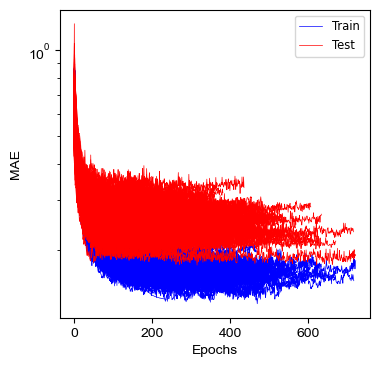

In [6]:
l_te = [[r for r in result['l_te']] for result in results]
l_tr = [[r for r in result['l_tr']] for result in results]
fig, ax = plt.subplots(figsize=(4, 4))
for i in l_tr:
    ax.plot(i, c='b', lw=0.5, label='Train')
    ax.set_yscale('log')
for i in l_te:
    ax.plot(i, c='r', lw=0.5, label='Test')
    ax.set_yscale('log')
ax.set_xlabel('Epochs', fontsize=10, family='Arial')
ax.set_ylabel('MAE', fontsize=10, family='Arial')
plt.yticks(fontname = "Arial", fontsize=10)
plt.xticks(fontname = "Arial", fontsize=10)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), fontsize='small')
plt.show()

In [7]:
### Separating the R2 score of each model
r_squared_values = [[r**2 for r in result['r_values']] for result in results]
df = pd.DataFrame(r_squared_values, columns=target_variables)
df_melted = df.melt(var_name='Element', value_name='R_squared')

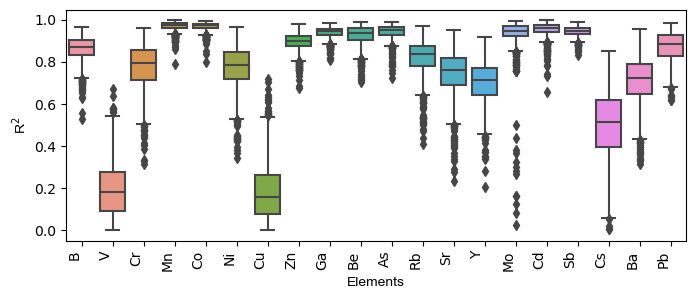

In [8]:
### Making a plot to have a view on the R2 score for each predicted element
fig, ax = plt.subplots(1,1, figsize=(8,3))
sns.boxplot(data=df_melted, x='Element', y='R_squared')
plt.xlabel('Elements', fontname = "Arial", fontsize=10)
plt.ylabel('R$^2$', fontname = "Arial", fontsize=10)
plt.xticks(rotation=90, ha='right')
plt.show()